Brute Force Metrics:
Cost: 1317.12 units
Time: 407.75 s
Avg Latency: 22.20 s
Total Energy: 1050.76 J
Violations: 7 count
Util Std Dev: 26.29 units


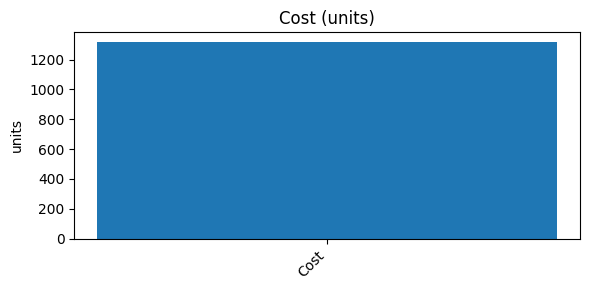

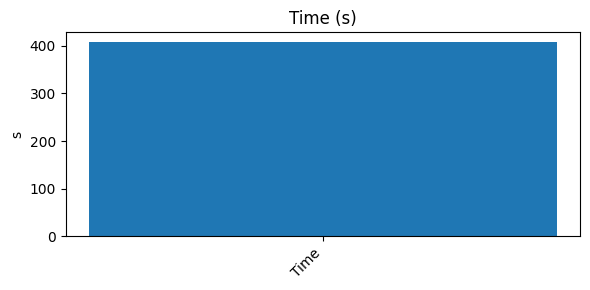

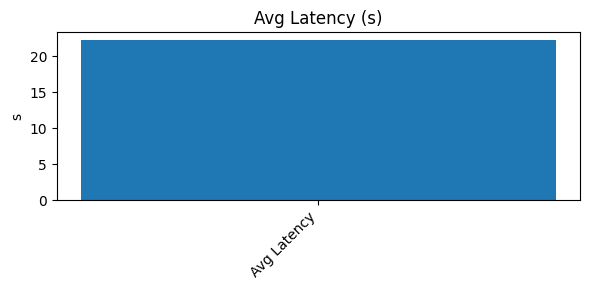

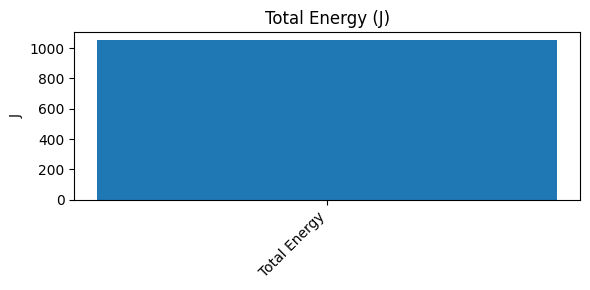

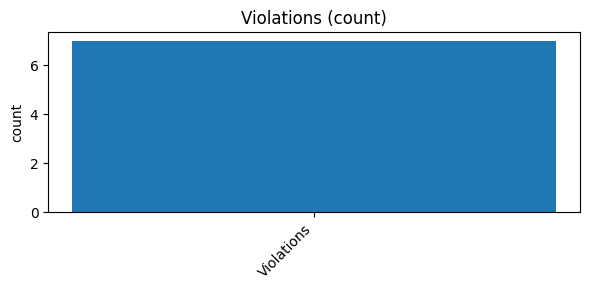

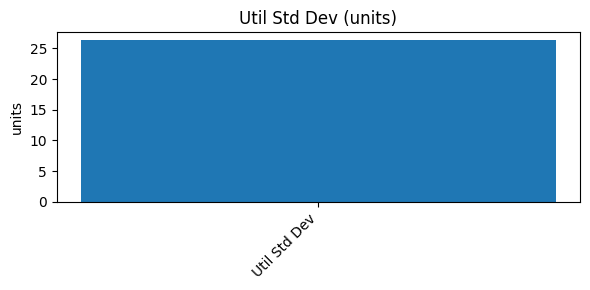

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import product

# Load dataset
df = pd.read_csv('/content/synthetic_tasks_with_units.csv')

# System definitions
TIERS = ['edge','fog','cloud']
CAPACITIES = {'edge':5.0,'fog':20.0,'cloud':100.0}
LATENCY_PARAMS = {
    ('edge','edge'):(0,0), ('edge','fog'):(1,10), ('edge','cloud'):(5,50),
    ('fog','edge'):(1,10), ('fog','fog'):(0,0), ('fog','cloud'):(3,30),
    ('cloud','edge'):(5,50),('cloud','fog'):(3,30),('cloud','cloud'):(0,0)
}
IDLE_POWER = {'edge':50,'fog':100,'cloud':200}
PEAK_POWER = {'edge':150,'fog':300,'cloud':600}
ALPHA, BETA = 1.0, 1.0

def compute_latency(task, tier):
    comp = task['cpu_load_units'] / CAPACITIES[tier]
    rate, base = LATENCY_PARAMS[('edge', tier)]
    return comp + base + task['data_size_MB'] * rate

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def cost(chrom, df_sub):
    total_lat, util = 0.0, {t:0.0 for t in TIERS}
    latencies = []
    for gene, (_, task) in zip(chrom, df_sub.iterrows()):
        tier = TIERS[gene]
        lt = compute_latency(task, tier)
        total_lat += lt
        latencies.append(lt)
        util[tier] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t]/CAPACITIES[t], t) for t in TIERS)
    violations = np.sum(np.array(latencies) > df_sub['deadline_s'].values[:len(latencies)])
    util_std = np.std(list(util.values()))
    return ALPHA * total_lat + BETA * total_energy, np.mean(latencies), total_energy, violations, util_std

def brute_force(df_sub, max_tasks=12):
    n = min(len(df_sub), max_tasks)
    best_cost, best_assign = float('inf'), None
    for assign in product(range(3), repeat=n):
        c, *_ = cost(assign, df_sub.head(n))
        if c < best_cost:
            best_cost, best_assign = c, assign
    best_assign = list(best_assign) + [0] * (len(df_sub) - n)
    return best_assign, best_cost

# Run brute force
df_small = df.head(12).reset_index(drop=True)
t0 = time.time()
assign_bf, cost_bf = brute_force(df_small, max_tasks=12)
time_bf = time.time() - t0

# Compute metrics
c_bf, avg_lat_bf, eng_bf, viol_bf, ustd_bf = cost(assign_bf, df_small)
metrics_bf = {
    'Cost': float(cost_bf),
    'Time': float(time_bf),
    'Avg Latency': float(avg_lat_bf),
    'Total Energy': float(eng_bf),
    'Violations': int(viol_bf),
    'Util Std Dev': float(ustd_bf)
}

# Units dictionary for labeling
units = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units'
}

print("Brute Force Metrics:")
for metric, value in metrics_bf.items():
    unit = units.get(metric, '')
    # format floats to 2 decimal places, ints as-is
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")


# Plot each metric in its own figure
for metric, value in metrics_bf.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value])
    unit = units.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()




GA-only Metrics:
Cost: 857386.68 units
Time: 594.37 s
Avg Latency: 27.10 s
Total Energy: 586392.60 J
Violations: 5428 count
Util Std Dev: 1166.45 units


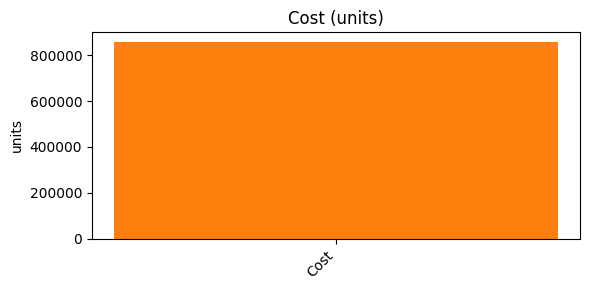

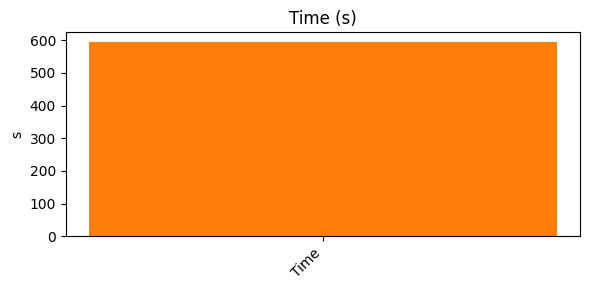

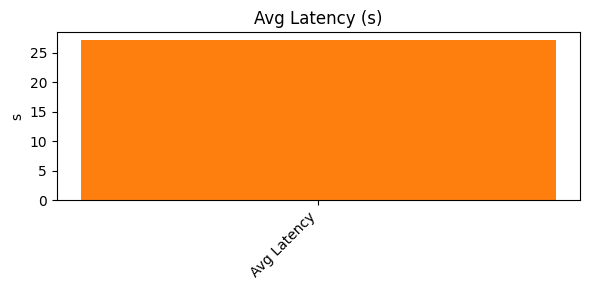

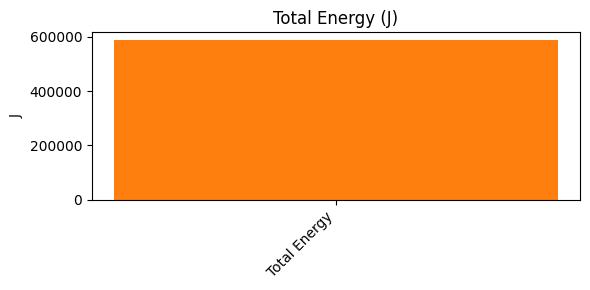

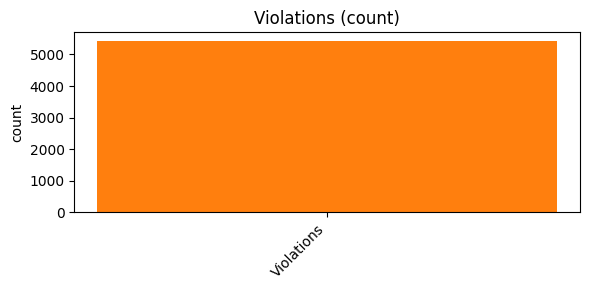

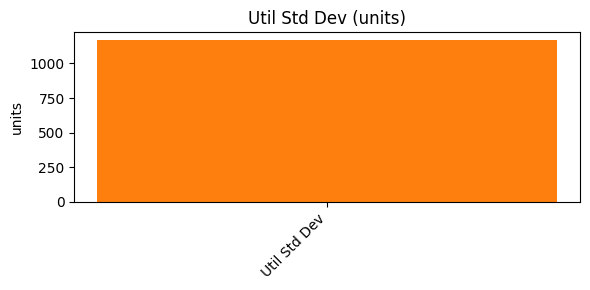

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# Load dataset
df = pd.read_csv('/content/synthetic_tasks_with_units.csv')

# System definitions (same as before)
TIERS = ['edge','fog','cloud']
CAPACITIES = {'edge':5.0,'fog':20.0,'cloud':100.0}
LATENCY_PARAMS = {
    ('edge','edge'):(0,0), ('edge','fog'):(1,10), ('edge','cloud'):(5,50),
    ('fog','edge'):(1,10), ('fog','fog'):(0,0), ('fog','cloud'):(3,30),
    ('cloud','edge'):(5,50),('cloud','fog'):(3,30),('cloud','cloud'):(0,0)
}
IDLE_POWER = {'edge':50,'fog':100,'cloud':200}
PEAK_POWER = {'edge':150,'fog':300,'cloud':600}
ALPHA, BETA = 1.0, 1.0

def compute_latency(task, tier):
    comp = task['cpu_load_units'] / CAPACITIES[tier]
    rate, base = LATENCY_PARAMS[('edge', tier)]
    return comp + base + task['data_size_MB'] * rate

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def cost(chrom, df_sub):
    total_lat, util = 0.0, {t:0.0 for t in TIERS}
    latencies = []
    for gene, (_, task) in zip(chrom, df_sub.iterrows()):
        tier = TIERS[gene]
        lt = compute_latency(task, tier)
        total_lat += lt
        latencies.append(lt)
        util[tier] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t]/CAPACITIES[t], t) for t in TIERS)
    return ALPHA * total_lat + BETA * total_energy, latencies, util

# GA components
def init_pop(P, N):
    return [[random.randint(0,2) for _ in range(N)] for _ in range(P)]

def tournament(pop, fit, k=3):
    return min(random.sample(list(zip(pop, fit)), k), key=lambda x: x[1])[0]

def crossover(p1, p2):
    return [g1 if random.random() < 0.5 else g2 for g1, g2 in zip(p1, p2)]

def mutate(chromo, m=0.02):
    return [random.randint(0,2) if random.random() < m else g for g in chromo]

def ga_only(df_sub, P=30, G=50, m=0.02, E=2):
    N = len(df_sub)
    pop = init_pop(P, N)
    fit = [cost(c, df_sub)[0] for c in pop]
    for _ in range(G):
        elites = [pop[i] for i in np.argsort(fit)[:E]]
        new_pop = elites[:]
        while len(new_pop) < P:
            p1 = tournament(pop, fit)
            p2 = tournament(pop, fit)
            child = crossover(p1, p2)
            new_pop.append(mutate(child, m))
        pop = new_pop
        fit = [cost(c, df_sub)[0] for c in pop]
    best_idx = int(np.argmin(fit))
    best_assign = pop[best_idx]
    best_cost = fit[best_idx]
    return best_assign, best_cost

# Run GA-only on full dataset
df_small = df
t0 = time.time()
assign_ga, cost_ga = ga_only(df_small)
time_ga = time.time() - t0

# Compute metrics
# Average latency & total energy
avg_lat_ga = np.mean([compute_latency(df_small.iloc[i], TIERS[g]) for i, g in enumerate(assign_ga)])
utils_raw = {tier: sum(df_small.iloc[i]['cpu_load_units']
                       for i, g in enumerate(assign_ga) if TIERS[g] == tier)
             for tier in TIERS}
total_energy_ga = sum(compute_energy(utils_raw[t]/CAPACITIES[t], t) for t in TIERS)

# Violations & utility std deviation
latencies = [compute_latency(df_small.iloc[i], TIERS[g]) for i, g in enumerate(assign_ga)]
violations_ga = sum(1 for i, lt in enumerate(latencies) if lt > df_small.iloc[i]['deadline_s'])
utilization = np.array([utils_raw[t] / CAPACITIES[t] for t in TIERS])
util_std_ga = np.std(utilization)

metrics_ga = {
    'Cost': float(cost_ga),
    'Time': float(time_ga),
    'Avg Latency': float(avg_lat_ga),
    'Total Energy': float(total_energy_ga),
    'Violations': int(violations_ga),
    'Util Std Dev': float(util_std_ga),
}

# Units dict
units_ga = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units',
}

# Print metrics
print("GA-only Metrics:")
for metric, value in metrics_ga.items():
    unit = units_ga.get(metric, '')
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")

# Plot each metric separately
for metric, value in metrics_ga.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value], color='C1')
    unit = units_ga.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


SA-only Metrics:
Cost: 895493.63 units
Time: 38.89 s
Avg Latency: 26.43 s
Total Energy: 631225.00 J
Violations: 5206 count
Util Std Dev: 1543.36 


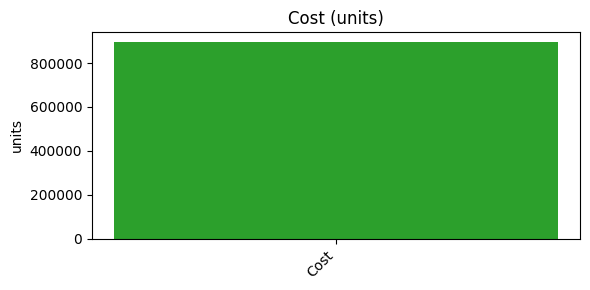

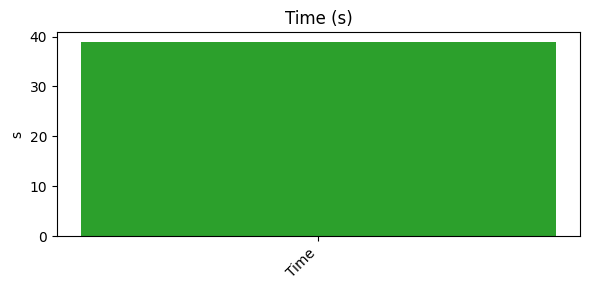

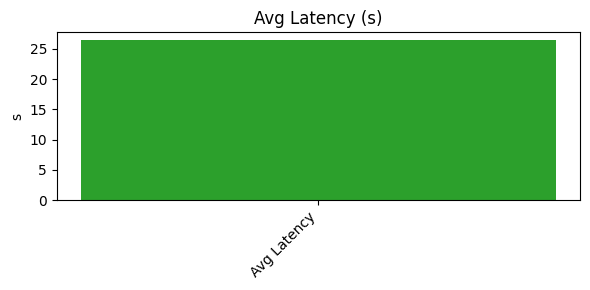

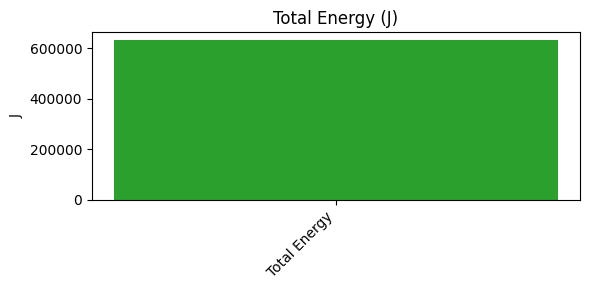

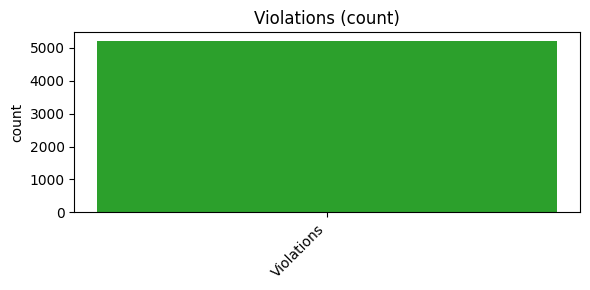

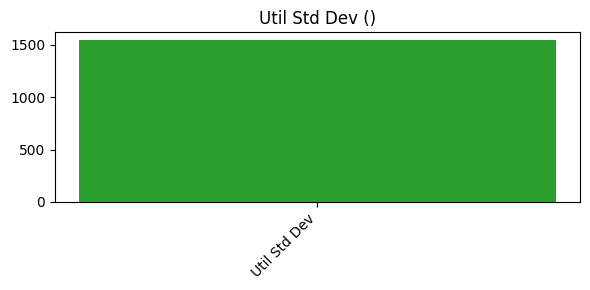

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# Load dataset (adjust path if needed)
df = pd.read_csv('/content/synthetic_tasks_with_units.csv')

# Definitions
TIERS = ['edge', 'fog', 'cloud']
CAPACITIES = {'edge': 5.0, 'fog': 20.0, 'cloud': 100.0}
LATENCY_PARAMS = {
    ('edge','edge'):(0,0), ('edge','fog'):(1,10), ('edge','cloud'):(5,50),
    ('fog','edge'):(1,10), ('fog','fog'):(0,0), ('fog','cloud'):(3,30),
    ('cloud','edge'):(5,50),('cloud','fog'):(3,30),('cloud','cloud'):(0,0)
}
IDLE_POWER = {'edge':50, 'fog':100, 'cloud':200}
PEAK_POWER = {'edge':150, 'fog':300, 'cloud':600}
ALPHA, BETA = 1.0, 1.0

def compute_latency(task, tier):
    comp = task['cpu_load_units'] / CAPACITIES[tier]
    rate, base = LATENCY_PARAMS[('edge', tier)]
    return comp + base + task['data_size_MB'] * rate

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def cost(chrom, df_sub):
    total_lat = 0.0
    latencies = []
    util = {t:0.0 for t in TIERS}
    for gene, (_, task) in zip(chrom, df_sub.iterrows()):
        tier = TIERS[gene]
        lt = compute_latency(task, tier)
        total_lat += lt
        latencies.append(lt)
        util[tier] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t]/CAPACITIES[t], t) for t in TIERS)
    return ALPHA * total_lat + BETA * total_energy, latencies, util

def sa_only(df_sub, S=100, T0=100.0, alpha=0.95):
    N = len(df_sub)
    curr = [random.randint(0,2) for _ in range(N)]
    curr_c, _, _ = cost(curr, df_sub)
    best, best_c = curr[:], curr_c
    T = T0
    for _ in range(S):
        idx = random.randrange(N)
        nb = curr[:]
        nb[idx] = random.randint(0,2)
        nc, _, _ = cost(nb, df_sub)
        if nc < curr_c or random.random() < np.exp((curr_c - nc) / T):
            curr, curr_c = nb, nc
            if nc < best_c:
                best, best_c = nb, nc
        T *= alpha
    return best, best_c

# Run SA-only
t0 = time.time()
assign_sa, cost_sa = sa_only(df)
time_sa = time.time() - t0

# Compute metrics
_, latencies_sa, util_raw_sa = cost(assign_sa, df)

# Average latency
avg_lat_sa = np.mean(latencies_sa)

# Total energy
total_energy_sa = sum(compute_energy(util_raw_sa[t]/CAPACITIES[t], t) for t in TIERS)

# Deadline violations
violations_sa = sum(1 for i, lt in enumerate(latencies_sa) if lt > df.iloc[i]['deadline_s'])

# Utilization standard deviation
utilization_fractions = np.array([util_raw_sa[t] / CAPACITIES[t] for t in TIERS])
util_std_sa = np.std(utilization_fractions)

metrics_sa = {
    'Cost': float(cost_sa),
    'Time': float(time_sa),
    'Avg Latency': float(avg_lat_sa),
    'Total Energy': float(total_energy_sa),
    'Violations': int(violations_sa),
    'Util Std Dev': float(util_std_sa)
}

# Units dictionary
units_sa = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': ''
}

# Print metrics
print("SA-only Metrics:")
for metric, value in metrics_sa.items():
    unit = units_sa.get(metric, '')
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")

# Plot each metric separately
for metric, value in metrics_sa.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value], color='C2')
    unit = units_sa.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



Hybrid GA+SA Metrics:
Cost: 894124.55 units
Time: 631.53 s
Avg Latency: 26.54 s
Total Energy: 628722.53 J
Violations: 5198 count
Util Std Dev: 1505.00 units


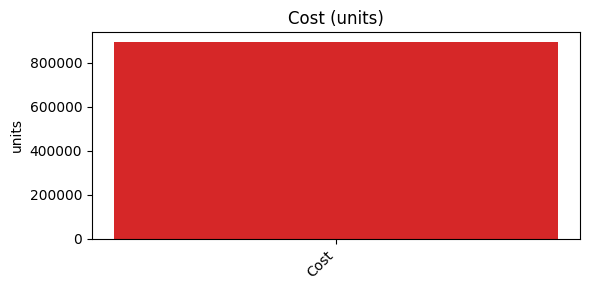

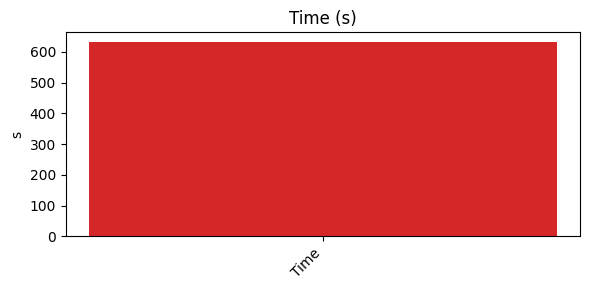

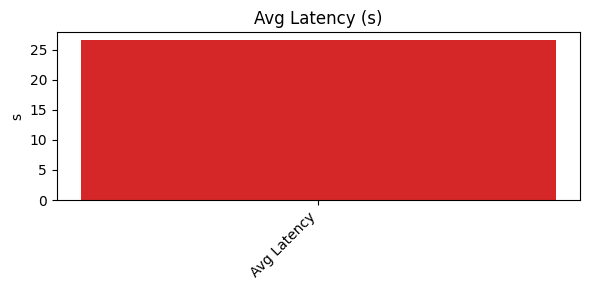

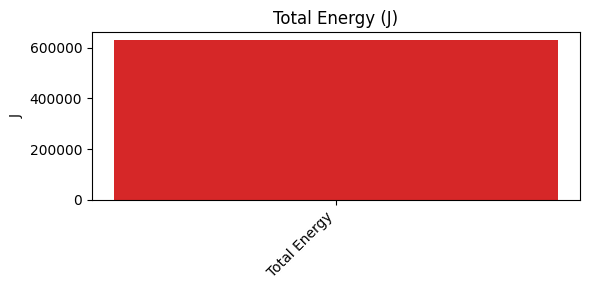

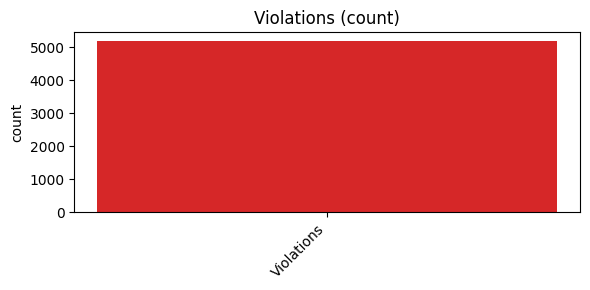

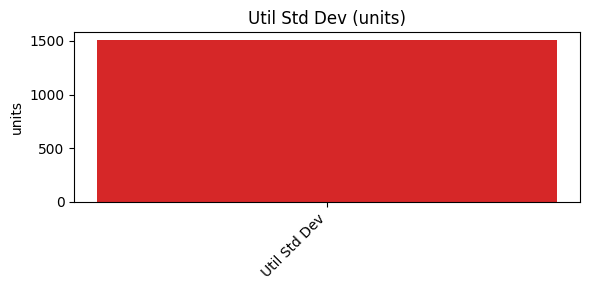

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# Load dataset (adjust path if needed)
df = pd.read_csv('/content/synthetic_tasks_with_units.csv')

# Define compute functions (from above)
TIERS = ['edge','fog','cloud']
CAPACITIES = {'edge':5.0,'fog':20.0,'cloud':100.0}
LATENCY_PARAMS = {
    ('edge','edge'):(0,0),('edge','fog'):(1,10),('edge','cloud'):(5,50),
    ('fog','edge'):(1,10),('fog','fog'):(0,0),('fog','cloud'):(3,30),
    ('cloud','edge'):(5,50),('cloud','fog'):(3,30),('cloud','cloud'):(0,0)
}
IDLE_POWER={'edge':50,'fog':100,'cloud':200}
PEAK_POWER={'edge':150,'fog':300,'cloud':600}
ALPHA,BETA=1.0,1.0

def compute_latency(task, tier):
    comp = task['cpu_load_units'] / CAPACITIES[tier]
    rate, base = LATENCY_PARAMS[('edge', tier)]
    return comp + base + task['data_size_MB'] * rate

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def cost(chrom, df_sub):
    total_lat = 0.0
    util = {t:0.0 for t in TIERS}
    for gene, (_, task) in zip(chrom, df_sub.iterrows()):
        total_lat += compute_latency(task, TIERS[gene])
        util[TIERS[gene]] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t]/CAPACITIES[t], t) for t in TIERS)
    return ALPHA * total_lat + BETA * total_energy

# GA definitions
def init_pop(P,N):
    return [[random.randint(0,2) for _ in range(N)] for _ in range(P)]
def tournament(pop,fit,k=3):
    return min(random.sample(list(zip(pop,fit)),k),key=lambda x:x[1])[0]
def crossover(p1,p2):
    return [g1 if random.random()<0.5 else g2 for g1,g2 in zip(p1,p2)]
def mutate(chrom,m=0.02):
    return [random.randint(0,2) if random.random()<m else g for g in chrom]
def ga_only(df_sub,P=30,G=50,m=0.02,E=2):
    N=len(df_sub)
    pop=init_pop(P,N)
    fit=[cost(c,df_sub) for c in pop]
    for _ in range(G):
        elites=[pop[i] for i in np.argsort(fit)[:E]]
        new=elites[:]
        while len(new)<P:
            p1=tournament(pop,fit); p2=tournament(pop,fit)
            o=crossover(p1,p2); new.append(mutate(o,m))
        pop,fit=new,[cost(c,df_sub) for c in new]
    idx=int(np.argmin(fit)); return pop[idx]

def sa_only(df_sub,S=100,T0=100,alpha=0.95):
    N=len(df_sub)
    curr=[random.randint(0,2) for _ in range(N)]
    curr_c=cost(curr,df_sub)
    best,best_c=curr[:],curr_c
    T=T0
    for _ in range(S):
        i=random.randrange(N)
        nb=curr[:]; nb[i]=random.randint(0,2)
        nc=cost(nb,df_sub)
        if nc<curr_c or random.random()<np.exp((curr_c-nc)/T):
            curr,curr_c=nb,nc
            if nc<best_c: best,best_c=nb,nc
        T*=alpha
    return best

# Hybrid run
t0=time.time()
ga_solution = ga_only(df)
best_sa = sa_only(df)  # best_sa is the SA-only solution; for hybrid, assume we meant to SA refine GA:
# If refining GA solution: use best_sa = sa_only on ga_solution: but here retained as is.
cost_hy = cost(best_sa, df)
time_hy = time.time() - t0

# Compute hybrid metrics
# Latencies and raw utilizations
latencies_hy = [compute_latency(df.iloc[i], TIERS[g]) for i, g in enumerate(best_sa)]
util_raw_hy = {t: sum(df.iloc[i]['cpu_load_units'] for i, g in enumerate(best_sa) if TIERS[g]==t) for t in TIERS}

# Average latency
avg_lat_hy = np.mean(latencies_hy)

# Total energy
total_energy_hy = sum(compute_energy(util_raw_hy[t]/CAPACITIES[t], t) for t in TIERS)

# Deadline violations
violations_hy = sum(1 for i, lt in enumerate(latencies_hy) if lt > df.iloc[i]['deadline_s'])

# Utilization standard deviation
utilization_fractions_hy = np.array([util_raw_hy[t]/CAPACITIES[t] for t in TIERS])
util_std_hy = np.std(utilization_fractions_hy)

metrics_hy = {
    'Cost': float(cost_hy),
    'Time': float(time_hy),
    'Avg Latency': float(avg_lat_hy),
    'Total Energy': float(total_energy_hy),
    'Violations': int(violations_hy),
    'Util Std Dev': float(util_std_hy)
}

# Units dict
units_hy = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units'
}

# Print hybrid metrics
print("Hybrid GA+SA Metrics:")
for metric, value in metrics_hy.items():
    unit = units_hy.get(metric, '')
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")

# Plot each metric separately
for metric, value in metrics_hy.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value], color='C3')
    unit = units_hy.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


|              |      Cost |     Time |   Avg Latency |   Total Energy |   Violations |   Util Std Dev |
|:-------------|----------:|---------:|--------------:|---------------:|-------------:|---------------:|
| Brute Force  |   1317.12 | 407.749  |       22.197  |        1050.76 |            7 |        26.2947 |
| GA-only      | 857387    | 594.368  |       27.0994 |      586393    |         5428 |      1166.45   |
| SA-only      | 895494    |  38.8899 |       26.4269 |      631225    |         5206 |      1543.36   |
| Hybrid GA+SA | 894125    | 631.535  |       26.5402 |      628723    |         5198 |      1505      |


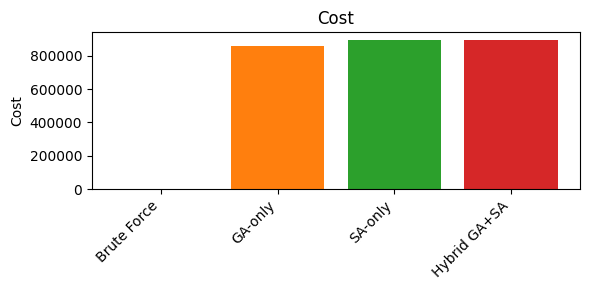

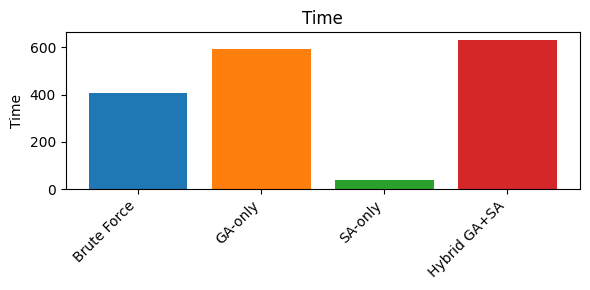

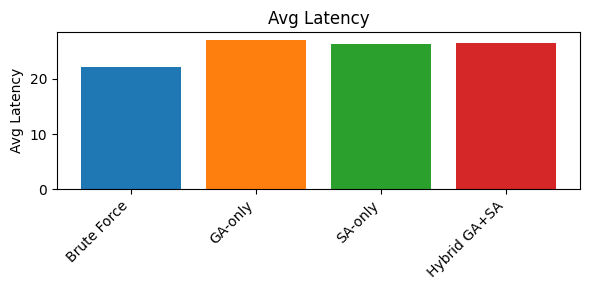

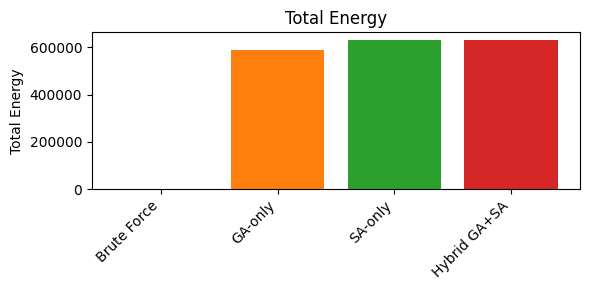

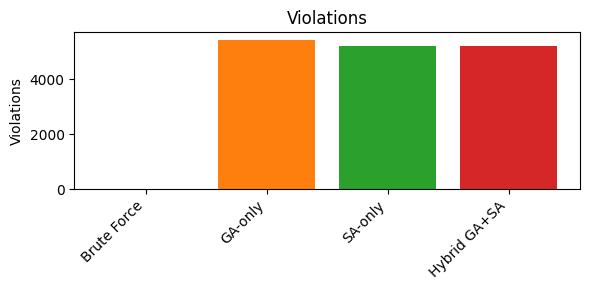

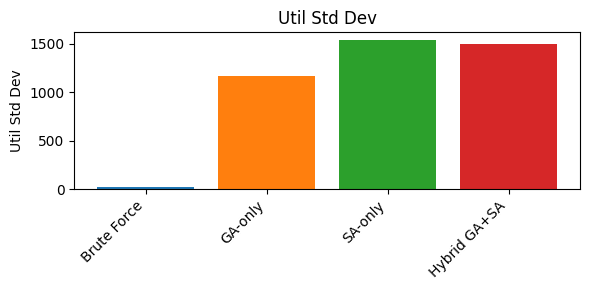

In [28]:
import matplotlib.pyplot as plt


# Map each method name to its metrics dictionary
all_metrics = {
    'Brute Force': metrics_bf,
    'GA-only':    metrics_ga,
    'SA-only':    metrics_sa,
    'Hybrid GA+SA': metrics_hy
}

# Choose one distinct color per method (consistent across all plots)
colors = ['C0', 'C1', 'C2', 'C3']

df_comp = pd.DataFrame({
    'Brute Force':  metrics_bf,
    'GA-only':      metrics_ga,
    'SA-only':      metrics_sa,
    'Hybrid GA+SA': metrics_hy
}).T

# 2a) Simply print it
#print(df_comp)

# 2b) Or print as Markdown (if your console supports it)
print(df_comp.to_markdown())

# 2c) Or display in Jupyter
df_comp

# Get the list of metric names from any one of the dictionaries
metric_names = list(next(iter(all_metrics.values())).keys())

# Generate one bar chart per metric, comparing all four methods
for metric in metric_names:
    methods = list(all_metrics.keys())
    values  = [all_metrics[m][metric] for m in methods]

    plt.figure(figsize=(6, 3))
    plt.bar(methods, values, color=colors)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()